# Aircraft Keypoint Detection from Satellite Images
---
Phase 1

In [1]:
import os
import ast
import shutil as sh
from pathlib import Path
import random

import numpy as np
import pandas as pd

import cv2
import PIL
import torch

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import geopandas as gpd
import json

from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

## Data visualization

In [2]:
def display_img(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

def display_multiple_images(img):
    for i in range(len(img)):
        plt.subplot(1, len(img), i+1)
        img[i] = PIL.Image.open(img[i])
        plt.imshow(img[i])
        plt.axis('off')
    plt.show()

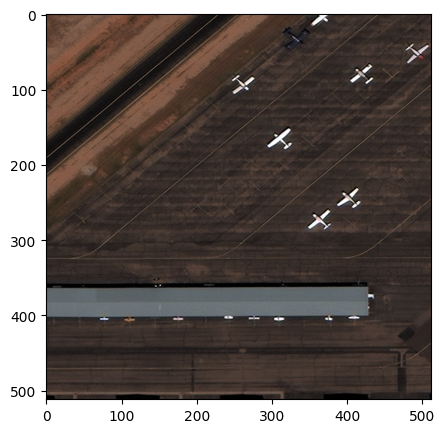

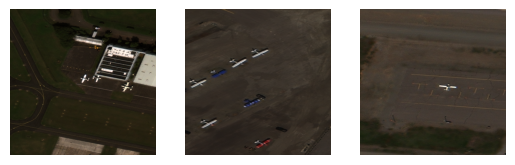

In [3]:
data_dir = Path('/kaggle/input/rareplane-dataset')
train_dir = data_dir / "train"
test_dir = data_dir / "test"

train_img_list = list(data_dir.glob('train/PS-RGB_tiled/*.png'))
test_img_list = list(data_dir.glob('test/PS-RGB_tiled/*.png'))

temp_1 = random.choice(train_img_list)
temp_1 = PIL.Image.open(temp_1)
display_img(temp_1)

temp_mul = [random.choice(train_img_list) for _ in range(3)]
display_multiple_images(temp_mul)

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = temp_1.size
num_channels = len(temp_1.mode)

print(f"Image size: ({IMAGE_HEIGHT},{IMAGE_WIDTH}) - Number of channels: {num_channels}")

Image size: (512,512) - Number of channels: 3


In [5]:
num_train = [train_dir / f.name for f in train_img_list if os.path.isfile(f) and f.name[-4:] == ".png"]
print("Found {} images files in {}".format(len(num_train), train_dir))

num_test = [test_dir / f.name for f in test_img_list if os.path.isfile(f) and f.name[-4:] == ".png"]
print("Found {} images files in {}".format(len(num_test), test_dir))

Found 5815 images files in /kaggle/input/rareplane-dataset/train
Found 2710 images files in /kaggle/input/rareplane-dataset/test


## Annotations
---
Read annotation files and use rectangle bounding box annotation to train model for phase 1 (aircraft detection)

In [6]:
train_anno_list = list(data_dir.glob('train/PS-RGB_tiled/*.xml'))

train_anno = []

for xml_file_path in train_anno_list:
    with open(xml_file_path, 'r') as file:
        xml_data = file.read()

    root = ET.fromstring(xml_data)

    data_dict = {}
    for elem in root.iter():
        if elem.tag == 'MDI':
            key = elem.get('key')
            value = elem.text
            data_dict[key] = [value]
    
    data_dict['filename'] = [xml_file_path.name]
    train_anno.append(data_dict)

train_anno_df = pd.DataFrame(train_anno)
train_anno_df.head(5)

,NODATA_VALUES,INTERLEAVE,HEIGHT_OFF,HEIGHT_SCALE,LAT_OFF,LAT_SCALE,LINE_DEN_COEFF,LINE_NUM_COEFF,LINE_OFF,LINE_SCALE,LONG_OFF,LONG_SCALE,SAMP_DEN_COEFF,SAMP_NUM_COEFF,SAMP_OFF,SAMP_SCALE,filename
0,[0 0 0],[PIXEL],[-21],[501],[26.4756],[0.0687],[1 -0.0003129832 0.0008404015 -1.060277e-06 -2...,[0.002074107 0.06187622 -1.075458 -0.01272315 ...,[-112488],[5311],[-80.1122],[0.0752],[1 -0.0001946307 -0.0006054436 -0.0004403915 2...,[0.004368211 1.023597 -0.0002458451 0.02220353...,[-30886],[5326],[86_1040010044D30600_tile_418.png.aux.xml]
1,[0 0 0],[PIXEL],[-21],[501],[26.4756],[0.0687],[1 -0.0003129832 0.0008404015 -1.060277e-06 -2...,[0.002074107 0.06187622 -1.075458 -0.01272315 ...,[-112897],[5311],[-80.1122],[0.0752],[1 -0.0001946307 -0.0006054436 -0.0004403915 2...,[0.004368211 1.023597 -0.0002458451 0.02220353...,[-28432],[5326],[86_1040010044D30600_tile_335.png.aux.xml]
2,[0 0 0],[PIXEL],[-23],[501],[26.8791],[0.068],[1 -0.0004020631 0.0003710826 -4.305487e-06 -1...,[0.001492211 0.04892735 -1.068484 -0.01868464 ...,[-215780],[5280],[-80.1256],[0.0713],[1 -0.0002632422 -0.0002373502 -0.0004572349 -...,[0.002768472 1.014308 0.0003353128 0.01325618 ...,[-23539],[5326],[106_1040010043890900_tile_73.png.aux.xml]
3,[0 0 0],[PIXEL],[171],[501],[48.7394],[0.0709],[1 -0.005992631 0.006787319 -0.0008192063 -2.9...,[0.02321304 0.1696948 -1.194662 0.02613351 -0....,[-32120],[4406],[2.093],[0.1125],[1 0.001023967 -0.004123306 -0.0003007509 -4.9...,[-0.005679246 1.031475 -4.702288e-05 -0.024511...,[-34902],[5325],[9_10400100310B0100_tile_195.png.aux.xml]
4,[0 0 0],[PIXEL],[22],[500],[64.4768],[0.0292],[1 0.0001467074 0.002503322 -3.461473e-05 -2.0...,[0.005217885 0.1748999 -1.201768 -0.02347089 0...,[-23204],[1956],[-165.4029],[0.1722],[1 -3.730171e-05 -0.0003202712 -0.0004168077 -...,[0.005899304 1.029817 -0.0007016984 0.02873199...,[-35864],[5326],[88_1040010019A43D00_tile_245.png.aux.xml]


In [7]:
train_anno_df['xml_filename'] = train_anno_df['filename']
train_anno_df['filename'] = train_anno_df['filename'].apply(lambda x: x[0].split('.')[0])
train_anno_df

,NODATA_VALUES,INTERLEAVE,HEIGHT_OFF,HEIGHT_SCALE,LAT_OFF,LAT_SCALE,LINE_DEN_COEFF,LINE_NUM_COEFF,LINE_OFF,LINE_SCALE,LONG_OFF,LONG_SCALE,SAMP_DEN_COEFF,SAMP_NUM_COEFF,SAMP_OFF,SAMP_SCALE,filename,xml_filename
0,[0 0 0],[PIXEL],[-21],[501],[26.4756],[0.0687],[1 -0.0003129832 0.0008404015 -1.060277e-06 -2...,[0.002074107 0.06187622 -1.075458 -0.01272315 ...,[-112488],[5311],[-80.1122],[0.0752],[1 -0.0001946307 -0.0006054436 -0.0004403915 2...,[0.004368211 1.023597 -0.0002458451 0.02220353...,[-30886],[5326],86_1040010044D30600_tile_418,[86_1040010044D30600_tile_418.png.aux.xml]
1,[0 0 0],[PIXEL],[-21],[501],[26.4756],[0.0687],[1 -0.0003129832 0.0008404015 -1.060277e-06 -2...,[0.002074107 0.06187622 -1.075458 -0.01272315 ...,[-112897],[5311],[-80.1122],[0.0752],[1 -0.0001946307 -0.0006054436 -0.0004403915 2...,[0.004368211 1.023597 -0.0002458451 0.02220353...,[-28432],[5326],86_1040010044D30600_tile_335,[86_1040010044D30600_tile_335.png.aux.xml]
2,[0 0 0],[PIXEL],[-23],[501],[26.8791],[0.068],[1 -0.0004020631 0.0003710826 -4.305487e-06 -1...,[0.001492211 0.04892735 -1.068484 -0.01868464 ...,[-215780],[5280],[-80.1256],[0.0713],[1 -0.0002632422 -0.0002373502 -0.0004572349 -...,[0.002768472 1.014308 0.0003353128 0.01325618 ...,[-23539],[5326],106_1040010043890900_tile_73,[106_1040010043890900_tile_73.png.aux.xml]
3,[0 0 0],[PIXEL],[171],[501],[48.7394],[0.0709],[1 -0.005992631 0.006787319 -0.0008192063 -2.9...,[0.02321304 0.1696948 -1.194662 0.02613351 -0....,[-32120],[4406],[2.093],[0.1125],[1 0.001023967 -0.004123306 -0.0003007509 -4.9...,[-0.005679246 1.031475 -4.702288e-05 -0.024511...,[-34902],[5325],9_10400100310B0100_tile_195,[9_10400100310B0100_tile_195.png.aux.xml]
4,[0 0 0],[PIXEL],[22],[500],[64.4768],[0.0292],[1 0.0001467074 0.002503322 -3.461473e-05 -2.0...,[0.005217885 0.1748999 -1.201768 -0.02347089 0...,[-23204],[1956],[-165.4029],[0.1722],[1 -3.730171e-05 -0.0003202712 -0.0004168077 -...,[0.005899304 1.029817 -0.0007016984 0.02873199...,[-35864],[5326],88_1040010019A43D00_tile_245,[88_1040010019A43D00_tile_245.png.aux.xml]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810,[0 0 0],[PIXEL],[-21],[501],[26.7783],[0.0682],[1 -0.0004093723 0.001031645 1.943622e-06 1.42...,[0.002607488 0.05287917 -1.070304 -0.01724197 ...,[-215026],[5295],[-80.1233],[0.072],[1 5.402494e-05 -0.0003095119 -0.000452342 -2....,[0.00249955 1.016963 -0.0003854639 0.01523907 ...,[-22877],[5326],106_10400100457A8A00_tile_72,[106_10400100457A8A00_tile_72.png.aux.xml]
5811,[0 0 0],[PIXEL],[22],[500],[64.4763],[0.0228],[1 0.0002119592 0.003018194 4.494924e-05 5.060...,[0.006160797 -0.07066678 -1.098229 -0.0239591 ...,[-26303],[1801],[-165.4052],[0.1464],[1 0.0005197834 0.0006876789 -0.0004273064 -4....,[-0.003334618 1.016038 -0.0005928243 -0.014516...,[-45886],[5325],87_1040010043467100_tile_23,[87_1040010043467100_tile_23.png.aux.xml]
5812,[0 0 0],[PIXEL],[98],[501],[47.1564],[0.0712],[1 -6.632678e-05 0.001328098 -3.928859e-05 -1....,[0.002155534 0.1067409 -1.119535 0.01239947 4....,[-161930],[4968],[-122.3087],[0.1133],[1 0.0003693248 0.001718879 -0.0004077242 -6.6...,[-0.00709255 1.033523 0.0002216614 -0.03022958...,[-29546],[5325],4_10400100360CD600_tile_726,[4_10400100360CD600_tile_726.png.aux.xml]
5813,[0 0 0],[PIXEL],[98],[501],[47.1564],[0.0712],[1 -6.632678e-05 0.001328098 -3.928859e-05 -1....,[0.002155534 0.1067409 -1.119535 0.01239947 4....,[-166838],[4968],[-122.3087],[0.1133],[1 0.0003693248 0.001718879 -0.0004077242 -6.6...,[-0.00709255 1.033523 0.0002216614 -0.03022958...,[-29137],[5325],4_10400100360CD600_tile_702,[4_10400100360CD600_tile_702.png.aux.xml]


In [8]:
test_all_annots = json.load(open('/kaggle/input/rareplanes-coco-annotations/RarePlanes_Test_Coco_Annotations_tiled.json', 'r'))
train_all_annots = json.load(open('/kaggle/input/rareplanes-coco-annotations/RarePlanes_Train_Coco_Annotations_tiled.json', 'r'))

In [9]:
train_annots_df = pd.DataFrame(train_all_annots['annotations'])
train_annots_df['loc_id'] = train_annots_df['loc_id'].astype(int)
train_images_df = pd.DataFrame(train_all_annots['images'])
train_label_df = train_annots_df.merge(train_images_df, left_on='image_id', right_on='id')
train_label_df

,segmentation,loc_id,cat_id,location,role,role_id,is_plane,num_engines,propulsion,canards,...,truncated,new_area,image_id,area_pixels,bbox,id_x,id_y,file_name,width,height
0,"[[340.8813896924257, 447.42630555294454, 243.1...",103,10400100080A3000,"Jackson Hole Airport, East Airport Road, Teton...",Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,0.0,538.071060,501,6933.776656,"[211.53270811587572, 379.9400369040668, 129.34...",1,501,103_10400100080A3000_tile_160.png,512,512
1,"[[412.69370121508837, 318.07762397266924, 309....",103,10400100080A3000,"Jackson Hole Airport, East Airport Road, Teton...",Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,0.0,550.796866,501,7097.810536,"[282.47981106489897, 248.42833388969302, 130.2...",2,501,103_10400100080A3000_tile_160.png,512,512
2,"[[478.44955272227526, 187.4311295337975, 375.4...",103,10400100080A3000,"Jackson Hole Airport, East Airport Road, Teton...",Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,0.0,628.656538,501,8101.196326,"[328.76846969127655, 119.94486088491976, 149.6...",3,501,103_10400100080A3000_tile_160.png,512,512
3,"[[512.0, 71.22793975286186, 451.8443891182542,...",103,10400100080A3000,"Jackson Hole Airport, East Airport Road, Teton...",Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,1.0,426.813736,501,5500.178267,"[428.0511533766985, 0.0, 83.9488466233015, 87....",4,501,103_10400100080A3000_tile_160.png,512,512
4,"[[8.043160244822502, 139.44331478793174, 0.0, ...",84,10400100460EF400,Fort Lauderdale-Hollywood International Airpor...,Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,1.0,494.434222,3327,3777.323548,"[0.0, 18.523396650329232, 56.63198579847813, 1...",5,3327,84_10400100460EF400_tile_323.png,512,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18388,"[[293.9129207506776, 278.72320561110973, 277.7...",113,10400100460EF400,"Pompano Beach Airpark, NE 5th Ave, Pompano Bea...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,47.652364,4965,364.584575,"[277.71664556860924, 260.87049319036305, 25.39...",18389,4965,113_10400100460EF400_tile_34.png,512,512
18389,"[[318.2073335275054, 213.01786196231842, 308.2...",113,10400100460EF400,"Pompano Beach Airpark, NE 5th Ave, Pompano Bea...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,44.894001,4965,343.481147,"[295.9374551475048, 198.10992685053498, 22.822...",18390,4965,113_10400100460EF400_tile_34.png,512,512
18390,"[[393.29915484040976, 334.3058772664517, 409.4...",113,10400100460EF400,"Pompano Beach Airpark, NE 5th Ave, Pompano Bea...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,42.545419,4965,325.511054,"[378.2071711458266, 334.3058772664517, 31.2882...",18391,4965,113_10400100460EF400_tile_34.png,512,512
18391,"[[384.83292008191347, 306.1464442759752, 390.1...",113,10400100460EF400,"Pompano Beach Airpark, NE 5th Ave, Pompano Bea...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,46.107245,4965,352.762591,"[384.83292008191347, 291.05446058139205, 24.11...",18392,4965,113_10400100460EF400_tile_34.png,512,512


In [10]:
test_annots_df = pd.DataFrame(test_all_annots['annotations'])
test_annots_df['loc_id'] = test_annots_df['loc_id'].astype(int)
test_images_df = pd.DataFrame(test_all_annots['images'])
test_label_df = test_annots_df.merge(test_images_df, left_on='image_id', right_on='id')
test_label_df

,segmentation,loc_id,cat_id,location,role,role_id,is_plane,num_engines,propulsion,canards,...,truncated,new_area,image_id,area_pixels,bbox,id_x,id_y,file_name,width,height
0,"[[77.8639263883233, 388.64122388884425, 17.629...",126,104001000C4AEE00,"816, Terminal 2 Departures, Pudong, Pudong New...",Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,1.0,410.008043,1495,4110.265203,"[0.0, 365.98989984951913, 77.8639263883233, 91...",1,1495,126_104001000C4AEE00_tile_1548.png,512,512
1,"[[512.0, 259.64327306859195, 444.4713506251573...",126,104001000C4AEE00,"816, Terminal 2 Departures, Pudong, Pudong New...",Large Civil Transport/Utility,3.0,1.0,2.0,jet,no,...,1.0,588.583392,1495,5900.499105,"[444.47135062515736, 119.10243207029998, 67.52...",2,1495,126_104001000C4AEE00_tile_1548.png,512,512
2,"[[30.047417155466974, 114.8998292516917, 45.81...",10,104001002E88FE00,"Aéroport de Montpellier - Méditerranée, D 66, ...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,49.096962,2369,613.623225,"[5.00252647115849, 110.57108271308243, 40.8138...",3,2369,10_104001002E88FE00_tile_45.png,512,512
3,"[[75.19005962321535, 137.62574857845902, 91.42...",10,104001002E88FE00,"Aéroport de Montpellier - Méditerranée, D 66, ...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,49.294943,2369,616.096934,"[49.8359727577772, 133.2970020417124, 41.58688...",4,2369,10_104001002E88FE00_tile_45.png,512,512
4,"[[121.10569254425354, 159.7332755383104, 136.1...",10,104001002E88FE00,"Aéroport de Montpellier - Méditerranée, D 66, ...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,46.248661,2369,578.023326,"[95.75160567858256, 155.24993091449142, 40.350...",5,2369,10_104001002E88FE00_tile_45.png,512,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6807,"[[490.41288235783577, 0.0, 489.8352559134364, ...",77,104001004299B200,Hartsfield–Jackson Atlanta International Airpo...,Medium Civil Transport/Utility,2.0,1.0,2.0,jet,no,...,1.0,213.363040,1144,2221.397822,"[398.92985067144036, 0.0, 91.4830316863954, 30...",6808,1144,77_104001004299B200_tile_629.png,512,512
6808,"[[22.258746944367886, 376.20721390098333, 13.3...",96,104001003C8C7800,"Fairbanks International Airport, Old Airport W...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,49.894969,2353,813.772713,"[13.340818978846073, 358.9658865071833, 49.147...",6809,2353,96_104001003C8C7800_tile_1461.png,512,512
6809,"[[116.39243098348379, 459.8375605791807, 121.5...",96,104001003C8C7800,"Fairbanks International Airport, Old Airport W...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,0.0,48.815578,2353,796.158415,"[74.97360999882221, 450.721456438303, 46.57140...",6810,2353,96_104001003C8C7800_tile_1461.png,512,512
6810,"[[210.72429122030735, 505.21990510076284, 212....",96,104001003C8C7800,"Fairbanks International Airport, Old Airport W...",Small Civil Transport/Utility,1.0,1.0,1.0,propeller,no,...,1.0,21.680552,2353,353.597337,"[177.73732632398605, 497.09468184784055, 35.04...",6811,2353,96_104001003C8C7800_tile_1461.png,512,512


### Visualize some images with rectangle bounding boxes

In [11]:
def draw_bboxes(img_path, bboxes):
    img = PIL.Image.open(img_path)
    img_array = np.array(img)
    plt.figure()

    plt.imshow(img_array)

    for bbox in bboxes:
        patch = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                          fill=False, edgecolor='b', linewidth=1.5)
        plt.gca().add_patch(patch)

    plt.show()

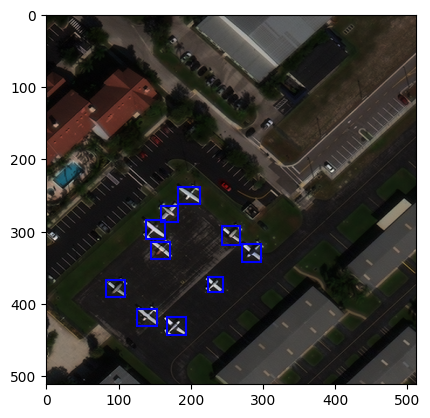

In [12]:
train_sample_img = train_label_df['file_name'].iloc[712]
train_sample_bboxes = train_label_df[train_label_df['file_name'] == train_sample_img]['bbox'].tolist()

draw_bboxes('/kaggle/input/rareplane-dataset/train/PS-RGB_tiled/' + train_sample_img, train_sample_bboxes)

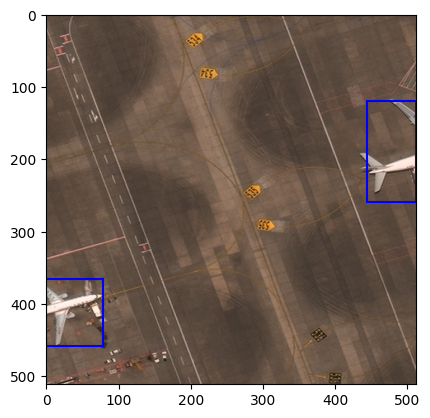

In [13]:
test_sample_img = test_label_df['file_name'].iloc[1]
test_sample_bboxes = test_label_df[test_label_df['file_name'] == test_sample_img]['bbox'].tolist()

draw_bboxes('/kaggle/input/rareplane-dataset/test/PS-RGB_tiled/' + test_sample_img, 
            test_sample_bboxes)

In [14]:
print(len(train_label_df['file_name'].unique()))
len(test_label_df['file_name'].unique())

5815


2710

## Prepare data for training

In [15]:
import random
import shutil
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_img_list, test_size=0.15, random_state=42)

train_dir = '/kaggle/working/train/images'

os.makedirs(train_dir, exist_ok=True)

for file in train_files:
    base_name = os.path.basename(file)
    shutil.copy(file, os.path.join(train_dir, base_name))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
val_dir = '/kaggle/working/val/images'
os.makedirs(val_dir, exist_ok=True)

for file in val_files:
    base_name = os.path.basename(file)
    shutil.copy(file, os.path.join(val_dir, base_name))

### Convert to YOLO annotation file format
-  class x-center y-center width height

In [17]:
def convert_annotation(bbox, image_width, image_height):
    x, y, width, height = bbox

    x_center = x / image_width + width / (2 * image_width)
    y_center = y / image_height + height / (2 * image_height)

    width_normalized = width / image_width
    height_normalized = height / image_height

    yolo_bbox_str = f"0 {x_center} {y_center} {width_normalized} {height_normalized}"

    return yolo_bbox_str

In [18]:
train_img_dir = os.path.join(train_dir, "images")
val_img_dir = os.path.join(val_dir, "images")

In [19]:
train_filenames = [os.path.splitext(os.path.basename(file))[0] for file in train_files]

In [20]:
train_anno = "/kaggle/working/train/labels"
val_anno = "/kaggle/working/val/labels"

In [21]:
os.makedirs(train_anno)
os.makedirs(val_anno)

In [22]:
 for index, row in train_label_df.iterrows():
    filename = row['file_name']
    name = filename[:-4]
    bbox = row['bbox']

    yolo_bbox_str = convert_annotation(bbox, 512, 512)
    
    txt_filename = f'{name}.txt' 

    if name in train_filenames:
        with open(os.path.join(train_anno, txt_filename), 'a') as file:
            file.write(yolo_bbox_str + '\n')
    else:
        with open(os.path.join(val_anno, txt_filename), 'a') as file:
            file.write(yolo_bbox_str + '\n')    

In [23]:
CONFIG = """
train: /kaggle/working/train/
val: /kaggle/working/val/

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("dataset.yaml", "w") as f:
    f.write(CONFIG)

## Training

In [24]:
!git clone https://github.com/ultralytics/yolov5  
!pip install -qr yolov5/requirements.txt  

Cloning into 'yolov5'...
remote: Enumerating objects: 16088, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 16088 (delta 10), reused 14 (delta 2), pack-reused 16056
Receiving objects: 100% (16088/16088), 14.65 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (11042/11042), done.


In [25]:
!rm -rf /kaggle/working/runs

In [26]:
!python /kaggle/working/yolov5/train.py --cfg yolov5s.yaml --imgsz 512 --batch-size 12 --epochs 10 --data /kaggle/working/dataset.yaml --weights yolov5s.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/kaggle/working/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=12, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up 

In [27]:
!ls yolov5/runs/train/exp

F1_curve.png					  results.png
PR_curve.png					  train_batch0.jpg
P_curve.png					  train_batch1.jpg
R_curve.png					  train_batch2.jpg
confusion_matrix.png				  val_batch0_labels.jpg
events.out.tfevents.1701980178.c1f6caeee234.75.0  val_batch0_pred.jpg
hyp.yaml					  val_batch1_labels.jpg
labels.jpg					  val_batch1_pred.jpg
labels_correlogram.jpg				  val_batch2_labels.jpg
opt.yaml					  val_batch2_pred.jpg
results.csv					  weights


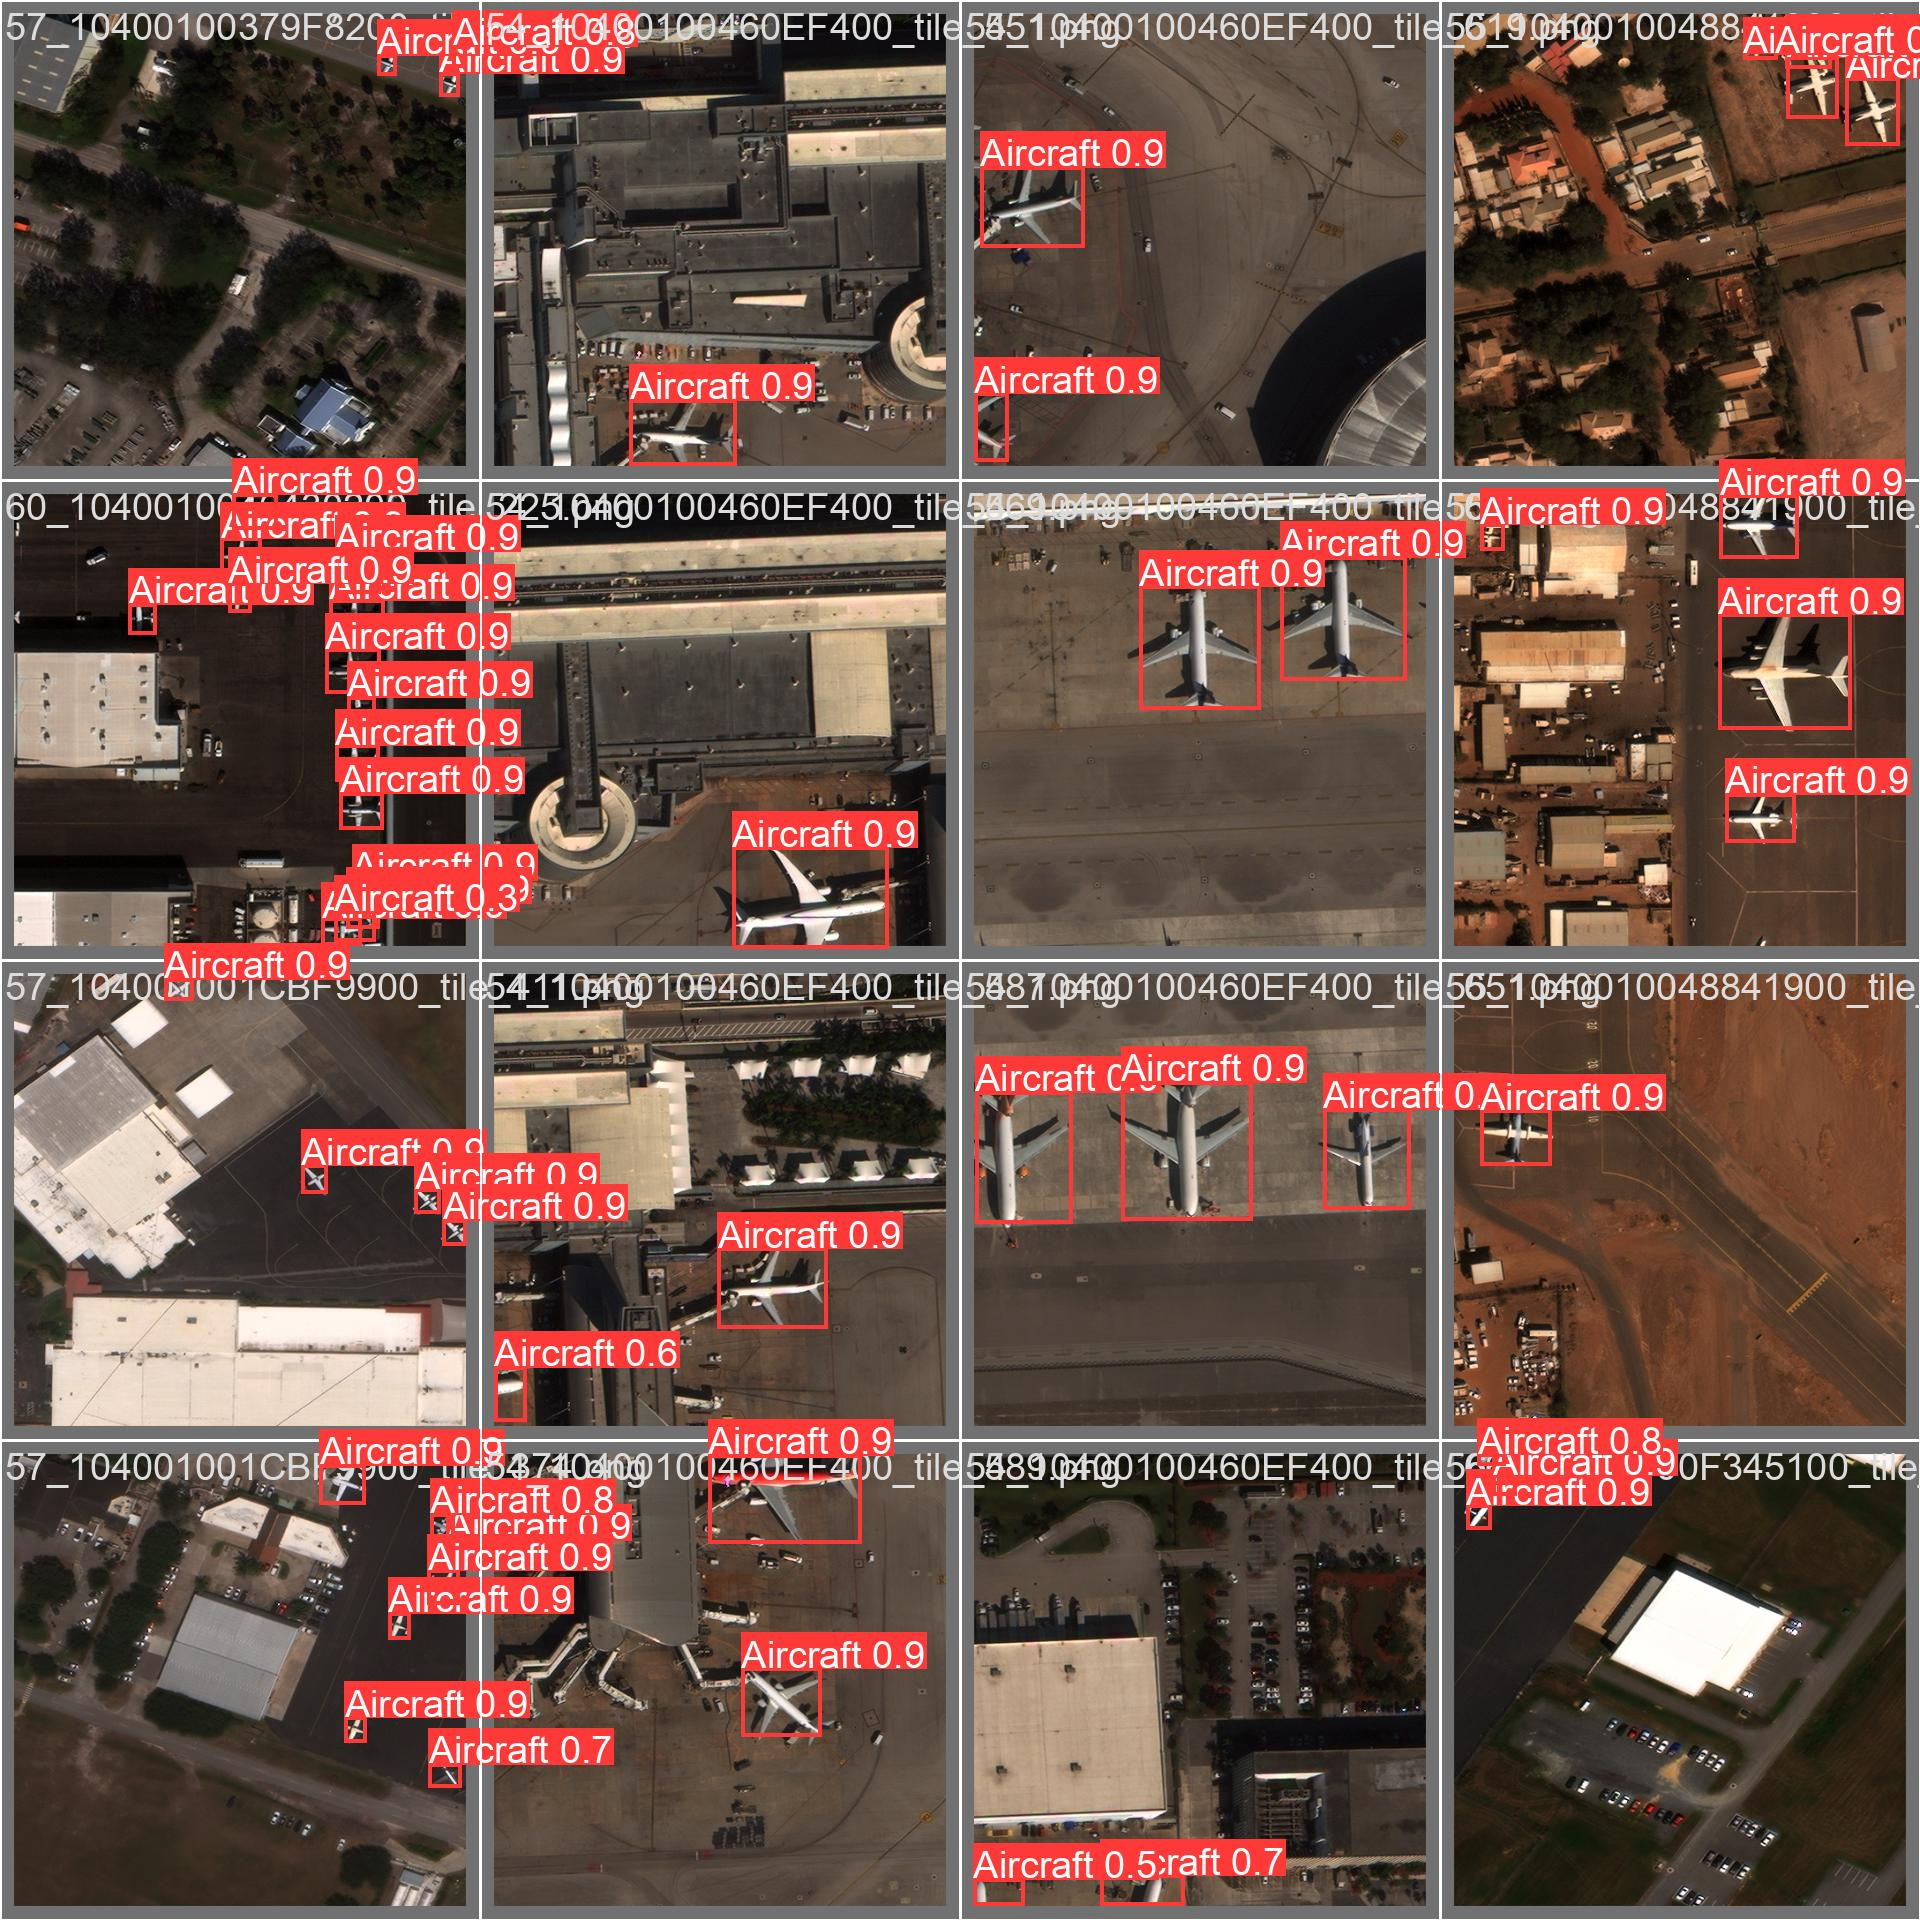

In [28]:
Image(filename='/kaggle/working/yolov5/runs/train/exp/val_batch1_pred.jpg', width=500)

## Detect objects on test set
- Save bounding boxes annotation to .txt files for phase 2

In [29]:
!rm -rf /kaggle/working/yolov5/runs/detect/
!python /kaggle/working/yolov5/detect.py --source /kaggle/input/rareplane-dataset/test/PS-RGB_tiled/ --img-size 512 --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt --conf 0.4 --save-txt

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/rareplane-dataset/test/PS-RGB_tiled/, data=yolov5/data/coco128.yaml, imgsz=[512, 512], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirement ['Pillow>=10.0.1'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.9s, installed 1 package: ['Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
im

### Visualize some images with detected aircrafts 

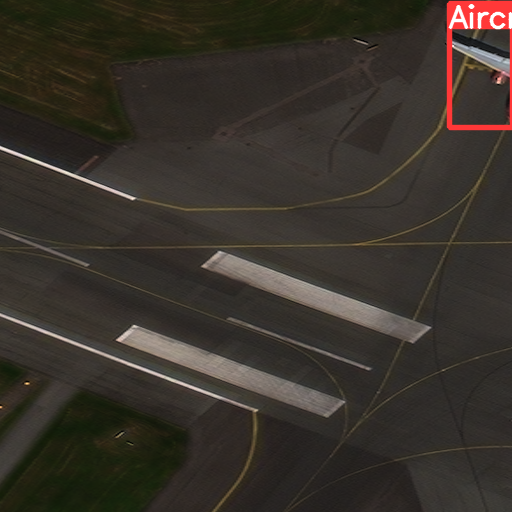

In [30]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('/kaggle/working/yolov5/runs/detect/exp/*.png'):
    display(Image(filename=image_path, width=512))
    break